# **Вариационные и проекционные методы решения краевых задач.**
## **Метод конечных элементов.**

<span style="font-style:normal; font-size:14pt;">
Решить численно разностным методом и методом конечных элементов с кусочно-линейными базисными функциями граничную задачу:

$$
\begin{cases}
\frac{\partial^2 u}{\partial x^2} = f(x), \: 0 < x < 1  \\
u(0) = 0  \\
u(1) = 0  \\
\end{cases} \\
f(x) = exp(-x)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Аналитическое решение
def solution(x):
    return np.exp(-x) + (1 - 1 / np.exp(1)) * x - 1

In [3]:
# Вычисление констант СЛАУ
def SLE_constants(x_plot, mu_1, mu_2, f):
    N = len(x_plot)
    h = x_plot[1] - x_plot[0]

    a_plot = np.zeros(N, dtype=float)
    b_plot = np.zeros(N, dtype=float)
    c_plot = np.zeros(N, dtype=float)
    f_plot = np.zeros(N, dtype=float)
    
    b_plot[0]     = 1
    b_plot[N - 1] = 1

    f_plot[0]     = mu_1
    f_plot[N - 1] = mu_2

    for i in range(1, N - 1):        
        a_plot[i] = 1 / h**2
        b_plot[i] = (-2) / h**2
        c_plot[i] = 1 / h**2
        f_plot[i] = f(x_plot[i])

    return a_plot, b_plot, c_plot, f_plot

In [4]:
# Метод прогонки для решения СЛАУ
def Thomas_algorithm(a_plot, b_plot, c_plot, f_plot):
    n = len(f_plot)
    y_plot = []
        
    A_plot = []
    B_plot = []
    
    A0 = (-1) * c_plot[0] / b_plot[0]
    B0 = f_plot[0] / b_plot[0]
    
    A_plot.append(A0)
    B_plot.append(B0)
    
    for i in range(1, n - 1):
        Ai = (-1) * c_plot[i] / (b_plot[i] + a_plot[i] * A_plot[i - 1])
        A_plot.append(Ai)
    
    for i in range(1, n):
        Bi = (f_plot[i] - a_plot[i] * B_plot[i - 1]) / (b_plot[i] + a_plot[i] * A_plot[i - 1])
        B_plot.append(Bi)
    
    An = 0   
    A_plot.append(An)    
    
    y_plot.append(B_plot[n - 1])
    
    for i in range(n - 2, -1, -1):
        yi = B_plot[i] + A_plot[i] * y_plot[0]
        y_plot.insert(0, yi)
    
    return y_plot

In [5]:
# Базис и его производные
def basis_i(x_plot, i):
    def psi_i(x):
        return np.piecewise( 
            x, 
            [x_plot[i - 1] <= x <= x_plot[i], 
             x_plot[i]     <  x <= x_plot[i + 1],
             x < x_plot[i - 1] or x > x_plot[i + 1],
            ],
            [
                lambda x: (x - x_plot[i - 1]) / (x_plot[i] - x_plot[i - 1]),
                lambda x: (x_plot[i + 1] - x) / (x_plot[i + 1] - x_plot[i]),
                lambda x: 0
            ])
    def dpsi_i(x):
        return np.piecewise( 
            x, 
            [x_plot[i - 1] <= x <= x_plot[i], 
             x_plot[i]     <  x <= x_plot[i + 1],
             x < x_plot[i - 1] or x > x_plot[i + 1],
            ],
            [
                lambda x: 1 / (x_plot[i] - x_plot[i - 1]),
                lambda x: (-1) / (x_plot[i + 1] - x_plot[i]),
                lambda x: 0
            ])
    return psi_i, dpsi_i

In [6]:
def calc_a(x_plot):
    N = len(x_plot) - 2
    A = np.zeros((N, N), dtype=float)
    
    for i in range(1, N + 1):
        for j in range(1, N + 1):
            if i == j:
                A[i - 1, j - 1] = 1 / (x_plot[i] - x_plot[i - 1]) + 1 / (x_plot[i + 1] - x_plot[i])
            elif i == j + 1 or j == i + 1:
                A[i - 1, j - 1] = (-1) / (x_plot[i + 1] - x_plot[i])
            else:
                A[i - 1, j - 1] = 0           
    return A

In [7]:
def calc_b(x_plot, f):
    N = len(x_plot) - 2
    B = np.zeros(N, dtype=float)
    
    for i in range(1, N + 1):
        h_i = x_plot[i] - x_plot[i - 1]
        B[i - 1] = f(x_plot[i]) * h_i
    return (-1) * B

### **Постановка задачи**

In [8]:
# Неоднородность
def f(x):
    return np.exp(-x) 

# Граничные условия
mu_1 = 0
mu_2 = 0

In [9]:
left  = 0
right = 1
h     = 0.1

x_plot = np.linspace(left, right, round((right - left) / h) + 1)

#### **Аналитическое решение**

In [10]:
u0_plot = solution(x_plot)

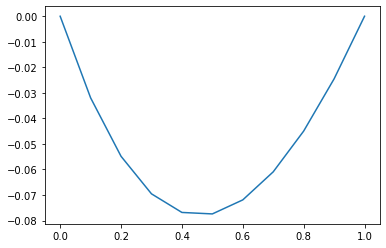

In [11]:
plt.plot(x_plot, u0_plot)

### **Конечно-разностный метод**

In [12]:
a1_plot, b1_plot, c1_plot, f1_plot = SLE_constants(x_plot, mu_1, mu_2, f)
u1_plot = Thomas_algorithm(a1_plot, b1_plot, c1_plot, f1_plot)

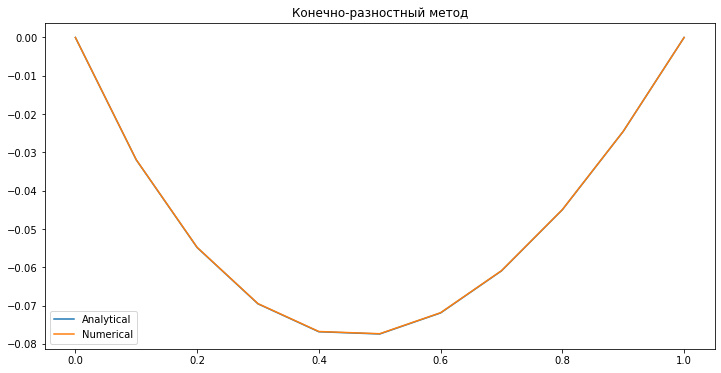

In [13]:
plt.figure(figsize=(12, 6))

plt.plot(x_plot, u0_plot, label="Analytical")
plt.plot(x_plot, u1_plot, label="Numerical")

plt.title("Конечно-разностный метод")
plt.legend()

In [14]:
np.max(np.abs(u1_plot - u0_plot))

6.44753097468892e-05

### **Метод конечных элементов**

In [15]:
A = calc_a(x_plot)
B = calc_b(x_plot, f)

In [16]:
N = len(x_plot) - 2

a2_plot = np.zeros(N, dtype=float)
b2_plot = np.zeros(N, dtype=float)
c2_plot = np.zeros(N, dtype=float)
f2_plot = np.zeros(N, dtype=float)

a2_plot[1:]  = A.diagonal(-1)
b2_plot      = A.diagonal()
c2_plot[:-1] = A.diagonal(1)
f2_plot = B

In [17]:
c_plot = np.array(Thomas_algorithm(a2_plot, b2_plot, c2_plot, f2_plot))

In [18]:
u2_plot = np.zeros(len(x_plot), dtype=float)

for i in range(1, len(x_plot) - 1):
    u2_plot += c_plot[i - 1] * np.array([basis_i(x_plot, i)[0](x) for x in x_plot])

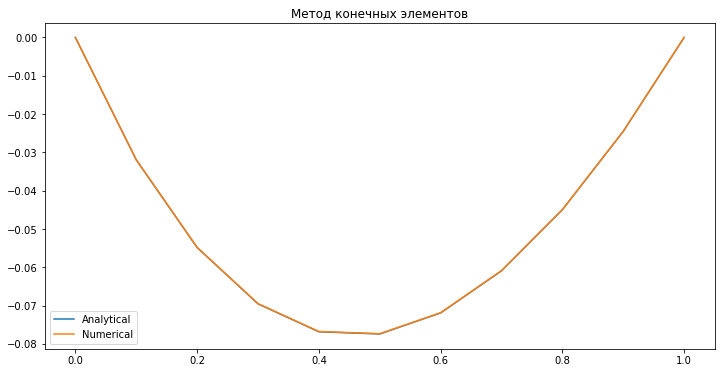

In [19]:
plt.figure(figsize=(12, 6))

plt.plot(x_plot, u0_plot, label="Analytical")
plt.plot(x_plot, u2_plot, label="Numerical")

plt.title("Метод конечных элементов")
plt.legend()

In [20]:
np.max(np.abs(u0_plot - u2_plot))

6.447530974687532e-05